In [22]:
from torch.utils.data import DataLoader
from Network.Mobilenet import MobileNet
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
import torch
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
from tqdm import tqdm
from torch import nn, int32, int64, float32, save
from sklearn.metrics import accuracy_score, f1_score

In [27]:
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", zoom_min = 20, zoom_max=25):
    # 예시 데이터
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg["loss"], marker="", linestyle="--",label="fedavg", color=tableau_colors[0])
    ax.plot(fedprox["loss"], marker="", linestyle="--" ,label="fedprox(mu=0.5)", color=tableau_colors[1])
    for i,l in enumerate(fedref):
        ax.plot(l["loss"], marker="", label=l["label"], color=tableau_colors[i+2], linestyle="--")

    # 메인 축 설정
    ax.set_title(title)
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend()
    # 🔍 확대 구간 설정 (마지막 x값 근처, 예: x > 90)
    x_zoom_min = zoom_min
    x_zoom_max = zoom_max

    # inset 축 생성
    axins = inset_axes(ax, width="30%", height="40%", loc='upper center')
    axins.plot(fedavg["loss"], color =tableau_colors[0], label = "fedavg", linestyle="--")
    axins.plot(fedprox["loss"], color =tableau_colors[1], label = "fedprox", linestyle="--")
    for i,l in enumerate(fedref):
        axins.plot(l["loss"], label=l["label"], color=tableau_colors[i+2], linestyle="--")
        
    alp = fedavg["loss"][zoom_min:zoom_max+1].to_list() + fedprox["loss"][zoom_min:zoom_max+1].to_list()
    for l in fedref:
        alp = alp + l["loss"][zoom_min:zoom_max+1].to_list()
    
    axins.set_xlim(x_zoom_min, x_zoom_max)
    #확대된 y축 범위도 지정하면 보기 쉬움
    #y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
    axins.set_ylim(bottom=min(alp), top = max(alp))
    
    # 확대된 영역 표시선 연결
    ax.indicate_inset_zoom(axins)
    ax.legend()
    
    minimum = [fedavg["loss"].min(), fedprox["loss"].min()] + [ s["loss"].min() for s in fedref]
    minimum = min(minimum)
    
    ax.set_ylim(bottom=minimum)
    fig.show()
    

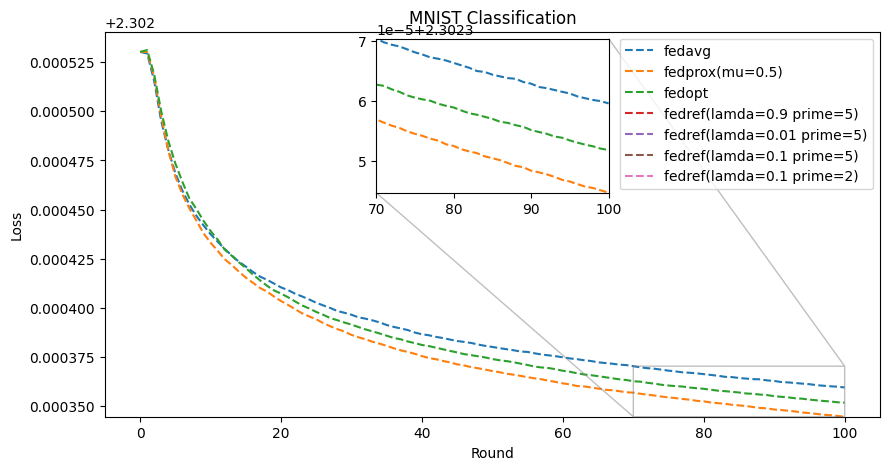

In [32]:
fedavg = pd.read_csv("Result/fedavg/FedAvg_mnist.csv")
fedprox = pd.read_csv("Result/fedprox/FedProx_mnist.csv")
fedopt = pd.read_csv(("Result/fedopt/FedOpt_mnist.csv"))
fedref1 = pd.read_csv("Result/fedref/FedRef_mnist_lda0.04_p5.csv")
fedref2 = pd.read_csv("Result/fedref/FedRef_mnist_lda0.1_p5.csv")
fedref3 = pd.read_csv("Result/fedref/FedRef_mnist_lda1.0_p5.csv")
fedref4 = pd.read_csv("Result/fedref/FedRef_mnist_lda1.0_p2.csv")
ploting(fedavg, fedprox, ({"loss":fedopt["loss"], "label": "fedopt"},
                            {"loss":fedref1["loss"], "label":"fedref(lamda=0.9 prime=5)"},
                            {"loss":fedref2["loss"], "label": "fedref(lamda=0.01 prime=5)"},
                            {"loss":fedref3["loss"], "label": "fedref(lamda=0.1 prime=5)"},
                            {"loss":fedref4["loss"], "label":"fedref(lamda=0.1 prime=2)"},
                            ), zoom_min=70, zoom_max=100, title="MNIST Classification")

In [4]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainset = datasets.MNIST("./Data", True, Compose([ToTensor(), Normalize((0.5), (0.5))]), None, True)
testset = datasets.MNIST("./Data", False, Compose([ToTensor(), Normalize((0.5), (0.5))]), None, True)
loader = DataLoader(trainset, 128, shuffle=True, collate_fn=lambda x:x)
tloader = DataLoader(testset, 128 , shuffle=True, collate_fn=lambda x:x)
lossf = torch.nn.CrossEntropyLoss().to(DEVICE)
net = MobileNet(outdim=10)
optim = torch.optim.SGD(net.parameters(), lr=4e-3)

In [5]:
def train(net, train_loader, valid_loader, epoch, lossf, optimizer, DEVICE, save_path):
    history = {}
    for e in range(epoch):
        net.train()
        for sample in tqdm(train_loader):
            X= torch.stack([s[0] for s in sample], 0)
            Y= torch.Tensor([s[1] for s in sample])
            out = net(torch.stack([X.type(float32).to(DEVICE),X.type(float32).to(DEVICE),X.type(float32).to(DEVICE)], 1).squeeze())
            loss = lossf(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE))
            loss.backward()
            optimizer.step()          
            optimizer.zero_grad()
        
        if valid_loader != None:
            # print("valid start")
            with torch.no_grad():
                for key, value in valid(net, valid_loader, e, lossf, DEVICE, True).items():
                    if e == 0:
                        history[key] = []
                    history[key].append(value)
            print(history)
        #if save_path is not None:            
        #   save(net.state_dict(), f"./Models/{save_path}/net.pt")
    if valid_loader is not None:                    
        return history
    else:
        return None
    
def valid(net, valid_loader, e, lossf, DEVICE, Central=False):
    net.eval()
    Dicenary = {'accuracy':0, 'f1score':0}
    length = len(valid_loader) 
    losses = 0
    #accf = Accuracy("multiclass", num_classes=10, multidim_average="global").to(DEVICE)
    #f1scoref = F1Score("multiclass", num_classes=10, multidim_average="global").to(DEVICE)
    accf = accuracy_score
    f1scoref = f1_score
    for sample in tqdm(valid_loader, desc="Validation: "):
    
        X= torch.stack([s[0] for s in sample], 0)
        Y= torch.Tensor([s[1] for s in sample])
    
        out = net(torch.stack([X.type(float32).to(DEVICE),X.type(float32).to(DEVICE),X.type(float32).to(DEVICE)], 1).squeeze()) 

        losses += lossf(out.type(float32).to(DEVICE), Y.type(int64).squeeze().to(DEVICE)).item()
        
        #print(Y.size())
        #Dicenary[f"accuracy"] += accf(out.cpu().type(float32).detach().numpy(), Y.unsqueeze(-1).type(int64).cpu().detach().numpy())
        #Dicenary[f"f1score"] += f1scoref(out.cpu().type(float32).detach().numpy(), Y.unsqueeze(-1).type(int64).cpu().detach().numpy(), average="weighted")

    # if Central:
        # logger.info(f"Result epoch {e+1}: loss:{losses/length} accuracy: {Dicenary["accuracy"]/length: .4f} f1score: {Dicenary["f1score"]/length: .4f}")
    return {"loss": losses/length}   
    #return {"loss":losses/length, 'accuracy': Dicenary["accuracy"]/length , "f1score":Dicenary["f1score"]/length}

In [6]:
#train(net.to(DEVICE), loader, tloader, 100, lossf=lossf, optimizer=optim, DEVICE=DEVICE, save_path=None)

Validation: 100%|██████████| 79/79 [00:02<00:00, 37.78it/s]


{'loss': [2.3016570399079144]}


Validation: 100%|██████████| 79/79 [00:02<00:00, 39.21it/s]


{'loss': [2.3016570399079144, 1.7953692855714243]}


Validation: 100%|██████████| 79/79 [00:01<00:00, 50.03it/s]


{'loss': [2.3016570399079144, 1.7953692855714243, 1.6879530888569505]}


 16%|█▌        | 74/469 [00:03<00:20, 19.32it/s]


KeyboardInterrupt: 

In [ ]:
#net.load_state_dict(torch.load("Models/FedProxMNIST/net.pt"))
#net.to(DEVICE)
#valid(net, tloader, 0, lossf, DEVICE)

/tmp/ipykernel_3387887/670052876.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedProxMNIST/net.pt"))
Validation: 100%|█████████

{'loss': 0.8451650882069068,
 'accuracy': 0.11293512658227849,
 'f1score': 0.20199453592055117}

In [ ]:
net.load_state_dict(torch.load("Models/FedOptMNIST/net.pt"))
net.to(DEVICE)
valid(net, tloader, 0, lossf, DEVICE)

/tmp/ipykernel_3387887/654475765.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedOptMNIST/net.pt"))
Validation: 100%|██████████

{'loss': 0.9102756931811948,
 'accuracy': 0.08890427215189874,
 'f1score': 0.16214643277568447}